In [1]:
import pyccl as ccl
print(f"I am using pyccl version {ccl.__version__}")
import numpy as np
import matplotlib.pyplot as plt
from scripts.presets import Presets
from scripts.data_vectors import DataVectors
from scripts.data_vector_metrics import DataVectorMetrics


I am using pyccl version 3.0.2


In [2]:
# This analysis will be done for a cosmology with the following parameters
# if you want to change the cosmology, you can do it here or just run without it.
# For now, we will keep it as is.
#cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# The class has default values for the maximal redshift and the resolution of redshifts.
# You can change them if you want to or run the default values.
# Since we are investigating the impact of the resolution of redshifts,
# we will keep the maximal redshift as is (for now) and only change the redshift resolution.
redshift_max = 3.5
redshift_resolution_1 = 300  # this is the first resolution of redshifts
redshift_resolution_2 = 5000  # this is the second resolution of redshifts
# Please note that the redshift resolution is the number of redshifts between 0 and redshift_max.
# Additionally, a lot of parametric sweeping is already coded into helper functions 
# so we will not need to worry about that for now.

# We will also investigate ell binning but for this particular exercise,
# we will keep the ell binning at default values.
#ell_min = 20
#ell_max = 2000
#n_ell = 50






Data saved to data_output/redshift_distributions/lens_bins_y10.npy
Data saved to data_output/redshift_distributions/source_bins_y10.npy
3.0 500
Data saved to data_output/redshift_distributions/lens_bins_y10.npy
Data saved to data_output/redshift_distributions/source_bins_y10.npy
6 2


WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error


[  20.           25.48549971   32.47553478   41.38276162   52.73301797
   67.19636573   85.62664797  109.11189562  139.03855924  177.17335808
  225.76757834  287.68997766  366.59614217  467.14429382  595.27028833
  758.53803815  966.58604771 1231.69642213 1569.5199407  2000.        ]
3.25 10000
Data saved to data_output/redshift_distributions/lens_bins_y10.npy
Data saved to data_output/redshift_distributions/source_bins_y10.npy
6 2


KeyboardInterrupt: 

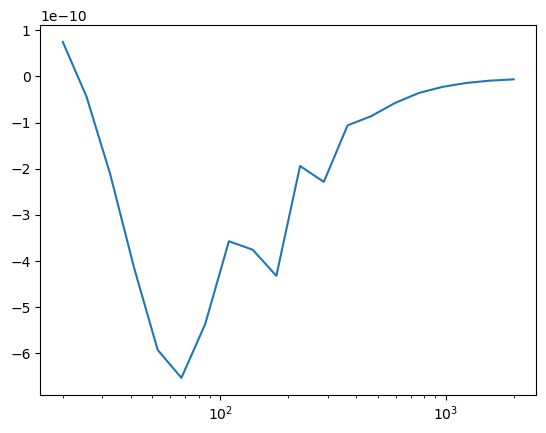

In [6]:
# This is the fiducial
forecast_year = "10"
presets = Presets(forecast_year=forecast_year, should_save_data=False)
data = DataVectors(presets)
cl_gc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
cl_ggl = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
cl_cs = np.array(data.cosmic_shear_cls(include_all_correlations=True))



N = 2
zet_max = np.linspace(3.,5,N)
zet_res = np.geomspace(500,10000,N).astype(int)
chi2 = np.zeros((N,N))


for i_max, val_max in enumerate(zet_max):
    for i_res, val_res in enumerate(zet_res):
        print(val_max, val_res)
        val_max = 3.25
        val_res= 1057

        

        presets_1 = Presets(redshift_max=val_max,
                        redshift_resolution=val_res,
                        forecast_year=forecast_year,should_save_data=False)

        data_1 = DataVectors(presets_1)
        correlation_pairs = (data_1.get_correlation_pairs_all()["galaxy_galaxy_lensing"])
        for idx_1, idx_2 in correlation_pairs[32:33]:
            print(idx_1,idx_2)
            ia_bias = data_1.get_ia_bias() 
            gbias = data_1.get_gbias() 
            tracer1 = ccl.NumberCountsTracer(
                    data_1.cosmology,
                    has_rsd=False,
                    dndz=(data_1.redshift_range, data_1.lens_bins[idx_1]),
                    bias=gbias
                )
            
            tracer2 = ccl.WeakLensingTracer(
                data_1.cosmology,
                dndz=(data_1.redshift_range, data_1.source_bins[idx_2]),
                ia_bias=ia_bias
            )
            #plt.plot(data_1.redshift_range,data_1.get_nc_kernel()[idx_1,0,:]/np.max(data_1.get_nc_kernel()[idx_1,0,:]))
            #plt.plot(data_1.redshift_range,data_1.get_wl_kernel()[idx_2,:]/np.max(data_1.get_wl_kernel()[idx_2,:]))
            cl_values = ccl.angular_cl(data_1.cosmology, tracer1, tracer2, data_1.ells)
            plt.semilogx(data_1.ells,cl_values)
            np.save("n_source", [data_1.redshift_range,data_1.source_bins[idx_2]])
            np.save("n_lens", [data_1.redshift_range,data_1.lens_bins_bins[idx_1]])
            
        #cl_gc_1 = np.array(data_1.galaxy_clustering_cls(include_all_correlations=True))
        cl_ggl_1 = np.array(data_1.galaxy_galaxy_lensing_cls(include_all_correlations=False))
        #cl_cs_1 = np.array(data_1.cosmic_shear_cls(include_all_correlations=True))

#        metric = DataVectorMetrics(presets)
        #chi2[i_max,i_res] = metric.get_delta_chi2(cl_gc, cl_ggl, cl_cs,cl_gc_1, cl_ggl_1, cl_cs_1)
fname = "./data_output/chi2/chi2_sweep_zmax_zres_y" + forecast_year 
np.savez(fname, zet_res=zet_res, zet_max=zet_max, chi2=chi2)

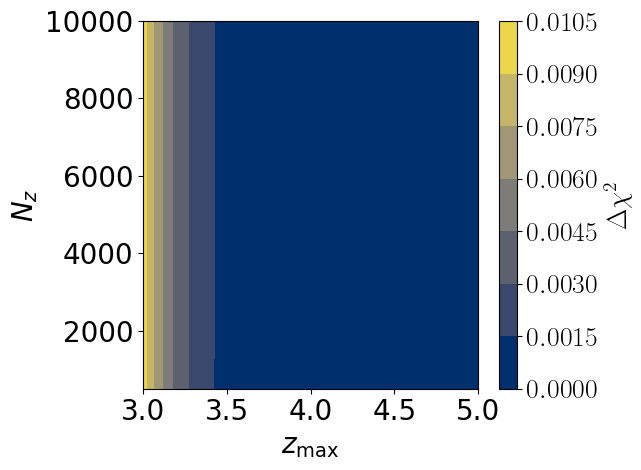

In [4]:
from matplotlib import cm, ticker

fontsi = 20
fontsi2 = 20


fig = plt.figure()
ax = fig.add_subplot()
plt.rc('text', usetex=True)


CS = plt.contourf(zet_max,zet_res,chi2.T,cmap = "cividis")#,  locator=ticker.LogLocator())
cb = plt.colorbar(CS)
plt.xlabel(r"$z_\mathrm{max}$", fontsize = fontsi)
plt.ylabel(r"$N_z$", fontsize = fontsi)
cb.set_label(r'$\Delta\chi^2$', fontsize=fontsi)
plt.tick_params(labelsize=fontsi2)

#plt.xscale("log")
#plt.yscale("log")

for t in cb.ax.get_yticklabels():
    t.set_fontsize(fontsi2)
plt.tight_layout()
fname = "./plots_output/chi2_zet_params_y" + forecast_year + ".pdf"
plt.savefig(fname)


In [5]:
forecast_year = "10"
presets = Presets(forecast_year=forecast_year, should_save_data=False)
data = DataVectors(presets)
cl_gc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
cl_ggl = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
cl_cs = np.array(data.cosmic_shear_cls(include_all_correlations=True))


N = 25
zet_max = np.linspace(3.,5,N)
zet_res = np.geomspace(500,10000,N).astype(int)
chi2 = np.zeros((N,N))

for i_max, val_max in enumerate(zet_max):
    for i_res, val_res in enumerate(zet_res):
        presets_1 = Presets(redshift_max=val_max,
                        redshift_resolution=val_res,
                        forecast_year=forecast_year,should_save_data=False)

        data_1 = DataVectors(presets_1)
        cl_gc_1 = np.array(data_1.galaxy_clustering_cls(include_all_correlations=True))
        cl_ggl_1 = np.array(data_1.galaxy_galaxy_lensing_cls(include_all_correlations=True))
        cl_cs_1 = np.array(data_1.cosmic_shear_cls(include_all_correlations=True))

        metric = DataVectorMetrics(presets)
        chi2[i_max,i_res] = metric.get_delta_chi2(cl_gc, cl_ggl, cl_cs,cl_gc_1, cl_ggl_1, cl_cs_1)

file = "./data_output/chi2/chi2_sweep_zmax_zres_y" + forecast_year 
np.savez(file, zet_res=zet_res, zet_max=zet_max, chi2=chi2)

WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_l

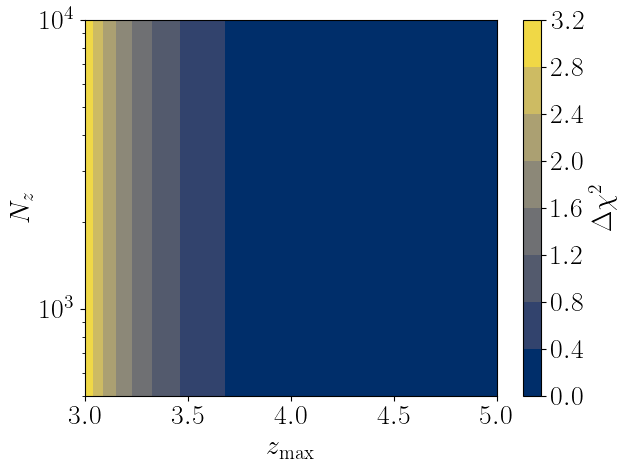

In [6]:
fontsi = 20
fontsi2 = 20


fig = plt.figure()
ax = fig.add_subplot()
plt.rc('text', usetex=True)


CS = plt.contourf(zet_max,zet_res,chi2.T,cmap = "cividis")#,  locator=ticker.LogLocator())
cb = plt.colorbar(CS)
plt.xlabel(r"$z_\mathrm{max}$", fontsize = fontsi)
plt.ylabel(r"$N_z$", fontsize = fontsi)
cb.set_label(r'$\Delta\chi^2$', fontsize=fontsi)
plt.tick_params(labelsize=fontsi2)

plt.xscale("linear")
plt.yscale("log")

for t in cb.ax.get_yticklabels():
    t.set_fontsize(fontsi2)
plt.tight_layout()
fname = "./plots_output/chi2_zet_params_y" + forecast_year + ".pdf"
plt.savefig("./plots_output/chi2_zet_params.pdf")

In [7]:
forecast_year = "1"
presets = Presets(forecast_year=forecast_year, should_save_data=False)
data = DataVectors(presets)
cl_gc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
cl_ggl = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
cl_cs = np.array(data.cosmic_shear_cls(include_all_correlations=True))

metric = DataVectorMetrics(presets)
chi2_fid_y1 = metric.get_delta_chi2(cl_gc, 
                                 cl_ggl,
                                 cl_cs,
                                 np.zeros_like(cl_gc),
                                 np.zeros_like(cl_ggl),
                                 np.zeros_like(cl_cs))


N = 50
number_ell = np.geomspace(20.,presets.ell_max,N).astype(int)
chi2_y1 = np.zeros(N)

for i_ell, val_ell in enumerate(number_ell):
    presets_1 = Presets(ell_num=val_ell,should_save_data=False)

    data_1 = DataVectors(presets_1)
    cl_gc_1 = np.array(data_1.galaxy_clustering_cls(include_all_correlations=True))
    cl_ggl_1 = np.array(data_1.galaxy_galaxy_lensing_cls(include_all_correlations=True))
    cl_cs_1 = np.array(data_1.cosmic_shear_cls(include_all_correlations=True))

    metric = DataVectorMetrics(presets_1)
    chi2_y1[i_ell] = np.abs((metric.get_delta_chi2(cl_gc_1, 
                                 cl_ggl_1,
                                 cl_cs_1,
                                 np.zeros_like(cl_gc_1),
                                 np.zeros_like(cl_ggl_1),
                                 np.zeros_like(cl_cs_1)) - chi2_fid_y1)/chi2_fid_y1)

file = "./data_output/chi2/chi2_number_ell_y" + forecast_year 
np.savez(file, zet_res=zet_res, zet_max=zet_max, chi2=chi2)

WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error
WARNING 18: ccl_cls.c: integ_cls_limber_qag_quad(): Default GSL integration failure, attempting backup method.: GSL ERROR: roundoff error


In [8]:
forecast_year = "10"
presets = Presets(forecast_year=forecast_year, should_save_data=False)
data = DataVectors(presets)
cl_gc = np.array(data.galaxy_clustering_cls(include_all_correlations=True))
cl_ggl = np.array(data.galaxy_galaxy_lensing_cls(include_all_correlations=True))
cl_cs = np.array(data.cosmic_shear_cls(include_all_correlations=True))

metric = DataVectorMetrics(presets)
chi2_fid_y10 = metric.get_delta_chi2(cl_gc, 
                                 cl_ggl,
                                 cl_cs,
                                 np.zeros_like(cl_gc),
                                 np.zeros_like(cl_ggl),
                                 np.zeros_like(cl_cs))


N = 50
number_ell = np.geomspace(20.,presets.ell_max,N).astype(int)
chi2_y10 = np.zeros(N)

for i_ell, val_ell in enumerate(number_ell):
    presets_1 = Presets(forecast_year=forecast_year,ell_num=val_ell,should_save_data=False)

    data_1 = DataVectors(presets_1)
    cl_gc_1 = np.array(data_1.galaxy_clustering_cls(include_all_correlations=True))
    cl_ggl_1 = np.array(data_1.galaxy_galaxy_lensing_cls(include_all_correlations=True))
    cl_cs_1 = np.array(data_1.cosmic_shear_cls(include_all_correlations=True))

    metric = DataVectorMetrics(presets_1)
    chi2_y10[i_ell] = np.abs((metric.get_delta_chi2(cl_gc_1, 
                                 cl_ggl_1,
                                 cl_cs_1,
                                 np.zeros_like(cl_gc_1),
                                 np.zeros_like(cl_ggl_1),
                                 np.zeros_like(cl_cs_1)) - chi2_fid_y10)/chi2_fid_y10)

file = "./data_output/chi2/chi2_number_ell_y" + forecast_year 
np.savez(file, zet_res=zet_res, zet_max=zet_max, chi2=chi2)

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/var/folders/4k/46233y0d3tx9bcbm7l78j0mr0000gn/T/ipykernel_79627/3522897430.py:19: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$", fontsize = fontsi)


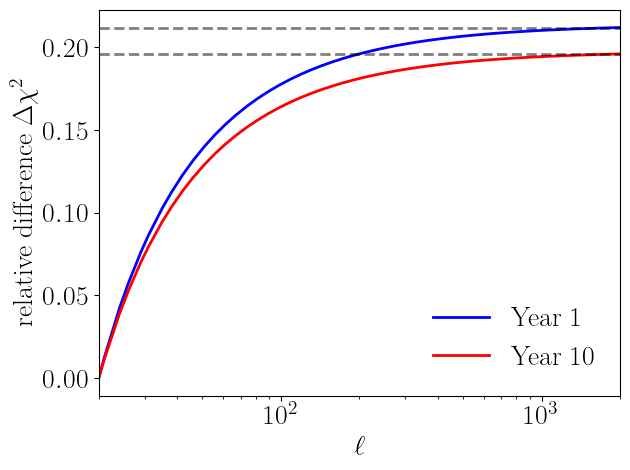

In [9]:
fontsi = 20
fontsi2 = 20
fig = plt.figure()
ax = fig.add_subplot()

plt.rc('text', usetex=True)





plt.plot(number_ell, chi2_y1, color = "blue", lw = 2, label = r"$\mathrm{Year\; 1}$")
plt.plot(number_ell, chi2_y10, color = "red", lw = 2, label = r"$\mathrm{Year\; 10}$")
plt.plot(number_ell, np.ones_like(number_ell)*chi2_y1[-1], ls = "--", color = "black", alpha =.5, lw = 2)
plt.plot(number_ell, np.ones_like(number_ell)*chi2_y10[-1], ls = "--", color = "black", alpha =.5, lw = 2)

plt.xscale("log")

plt.xlabel("$\ell$", fontsize = fontsi)
plt.ylabel(r"$\mathrm{relative\;difference\;}\Delta\chi^2$", fontsize = fontsi)
plt.tick_params(labelsize=fontsi2)
plt.xlim(number_ell[0],number_ell[-1])
ax.legend( frameon = False, fontsize =fontsi, loc = "best")
plt.tight_layout()
plt.savefig("./plots_output/chi2_ell_num.pdf")

